In [1]:
import pandas as pd
import numpy as np
import random
import csv
from prettytable import PrettyTable
from pylab import *
from scipy.stats import wasserstein_distance
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [2]:
###Change the data file directory below appropriately
data = pd.read_csv('../raw_data/0A986513-7828-4D53-AA1F-E02D6DF9561B.features_labels.csv')
#data = pd.read_csv('../aggregated_data/aggregated_data.csv')
data.head()

,timestamp,raw_acc:magnitude_stats:mean,raw_acc:magnitude_stats:std,raw_acc:magnitude_stats:moment3,raw_acc:magnitude_stats:moment4,raw_acc:magnitude_stats:percentile25,raw_acc:magnitude_stats:percentile50,raw_acc:magnitude_stats:percentile75,raw_acc:magnitude_stats:value_entropy,raw_acc:magnitude_stats:time_entropy,...,label:STAIRS_-_GOING_DOWN,label:ELEVATOR,label:OR_standing,label:AT_SCHOOL,label:PHONE_IN_HAND,label:PHONE_IN_BAG,label:PHONE_ON_TABLE,label:WITH_CO-WORKERS,label:WITH_FRIENDS,label_source
0,1449601597,1.000371,0.007671,-0.016173,0.027860,0.998221,1.000739,1.003265,0.891038,6.684582,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
1,1449601657,1.000243,0.003782,-0.002713,0.007046,0.998463,1.000373,1.002088,1.647929,6.684605,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
2,1449601717,1.000811,0.002082,-0.001922,0.003575,0.999653,1.000928,1.002032,1.960286,6.684610,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
3,1449601777,1.001245,0.004715,-0.002895,0.008881,0.999188,1.001425,1.003500,1.614524,6.684601,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
4,1449601855,1.001354,0.065186,-0.096520,0.165298,1.000807,1.002259,1.003631,0.837790,6.682252,...,0.0,NaN,0.0,1.0,NaN,NaN,NaN,NaN,0.0,2


# Interpolating columns with average values

In [3]:
def interpolation(df):
    col_to_avg = list(df.columns) #Start with keeping all the columns as columns to use an average interpolation on
    for k in range(len(list(df.columns))):
        if list(df.columns)[k].startswith(('discrete', 'label')): #Remove label and discrete columns from col_to_avg
            col_to_avg.remove(list(df.columns)[k])
    
    df_with_avg = df[col_to_avg].fillna(df[col_to_avg].mean()) #Interpolate nan columns for all continuous-valued columns with average
    
    col_to_zero = list(df.columns)
    for k in range(len(list(df.columns))):
        if not list(df.columns)[k].startswith(('discrete', 'label')): #Remove all columns except label and discrete
            col_to_zero.remove(list(df.columns)[k])
    
    df_with_zero = df[col_to_zero].fillna(0) #Interpolate nan values for label and discrete columns with 0
    
    return pd.concat([df_with_avg, df_with_zero], axis = 1)

# Splitting the data and loading it into a PyTorch dataloader

In [4]:
X = data.iloc[:,1:27]
y = data[['label:SITTING']]

X = X[y['label:SITTING'] == 1]
y = y[y['label:SITTING'] == 1]

X = interpolation(X).values
y = interpolation(y).values

print(len(X), len(y))

2253 2253


In [5]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(X)
#X

# Helper Functions for Training

In [6]:
def generator_block(input_dim, output_dim):
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.Dropout(0.1),
        nn.BatchNorm1d(output_dim),
        nn.ReLU(inplace = True)
    )
def get_noise(n_samples, z_dim):
    return torch.randn(n_samples, z_dim)

class Generator(nn.Module):
    def __init__(self, z_dim = 10, feature_dim = 26, hidden_dim = 128):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
             generator_block(z_dim, 80),
            generator_block(80, 60),
            generator_block(60, 40),
            generator_block(40, 28),
            nn.Linear(28, feature_dim)
        )
    def forward(self, noise):
        return self.gen(noise)

def discriminator_block(input_dim, output_dim):
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.Dropout(0.1),
        nn.LeakyReLU(0.05)
    )

class Discriminator(nn.Module):
    def __init__(self, feature_dim = 26, hidden_dim = 16):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            discriminator_block(feature_dim, hidden_dim),
            discriminator_block(hidden_dim, int(hidden_dim/2)),
            discriminator_block(int(hidden_dim/2), int(hidden_dim/4)),
            nn.Linear(int(hidden_dim/4), 1),
            nn.Sigmoid()                    
        )
    def forward(self, feature_vector):
        return self.disc(feature_vector)

def get_disc_loss(gen, disc, criterion, real_features, batch_size, z_dim):
    latent_vectors = get_noise(batch_size, z_dim)
    fake_features = gen(latent_vectors)
    pred_fake = disc(fake_features.detach())
    
    ground_truth = torch.zeros_like(pred_fake)
    loss_fake = criterion(pred_fake, ground_truth)
    
    pred_real = disc(real_features)
    ground_truth = torch.ones_like(pred_real)
    loss_real = criterion(pred_real, ground_truth)
    
    disc_loss = (loss_fake + loss_real) / 2
    return disc_loss

def get_gen_loss(gen, disc, criterion, batch_size, z_dim):
    latent_vectors = get_noise(batch_size, z_dim)
    fake_features = gen(latent_vectors)
    pred = disc(fake_features)
    gen_loss = criterion(pred, torch.ones_like(pred))
    return gen_loss

def visualize_gen_batch(gen, b_size, epochs = -1):
    #print(str(b_size))
    latent_vectors = get_noise(b_size, z_dim)
    #print(latent_vectors.shape)
    fake_features = gen(latent_vectors)
    #print(fake_features.shape)
    
    w_img = fake_features
    wmin = torch.min(w_img)
    wmax = torch.max(w_img)
    w_img = w_img.cpu()
    w_img = w_img.detach().numpy()
    c = plt.imshow(w_img, cmap ='Reds', vmin = wmin , vmax = wmax,
                        interpolation ='nearest', origin ='upper')
    plt.colorbar(c)
    plt.title('Generated Batch at Epoch ' + str(epochs), fontweight ="bold")
    plt.show()
    
def visualize_real_batch(features):
    w_img = features
    wmin = torch.min(w_img)
    wmax = torch.max(w_img)
    w_img = w_img.cpu()
    w_img = w_img.detach().numpy()
    c = plt.imshow(w_img, cmap ='Reds', vmin = wmin , vmax = wmax,
                        interpolation ='nearest', origin ='upper')
    plt.colorbar(c)
    plt.title('Real Batch of Data', fontweight ="bold")
    plt.show()
    
def performance_stats(gen, disc, b_size, batch = None):
    tp = 0
    fp = 0
    tn = 0
    fn = 0

    with torch.no_grad():
        if batch is None:
            latent_vectors = get_noise(b_size, z_dim)
            fake_features = gen(latent_vectors)
            y_hat = torch.round(disc(fake_features))
            y_label = [0] * b_size
            y_label = torch.Tensor(y_label)
        else:
            latent_vectors = get_noise(int(b_size/2), z_dim)
            fake_features = gen(latent_vectors)
            y_hat = torch.round(disc(fake_features))
            y_label = [0] * int(b_size/2)
            
            real_y_hat = torch.round(disc(batch[:int(b_size/2)]))
            for i in range(0, int(b_size/2)):
                y_label.append(1)
            y_hat = torch.cat((y_hat, real_y_hat), dim = 0)
            
            #print(y_hat)
            #print(y_label)
         
        
        for k in range(len(y_hat)):
            #True positive
            if y_label[k] == 1 and y_hat[k] == 1:
                tp += 1
            #False Negative
            elif y_label[k] == 1 and y_hat[k] == 0:
                fn += 1
            #True Negative
            elif y_label[k] == 0 and y_hat[k] == 0:
                tn += 1
            elif y_label[k] == 0 and y_hat[k] == 1:
                fp += 1
            else:
                print("Error")
                exit()
            
        class_acc = (tp + tn)/(tp + tn + fp + fn)
        
        if tp + fp == 0:
            precision = 0
        else:
            precision = tp / (tp + fp)
            
        if tp + fn == 0:
            recall = 0
        else:
            recall = tp / (tp + fn)
            
        if fp + tn == 0:
            fpR = 0
        else: 
            fpR = fp / (fp + tn)

        #print(f'Classification Accuracy: {class_acc:.2f}')
        #print(f'Precision: {precision:.2f}') #What percentage of a model's positive predictions were actually positive
        #print(f'Recall: {recall:.2f}') #What percent of the true positives were identified
        #print(f'F-1 Score: {2*(precision * recall / (precision + recall + 0.001)):.2f}')
        return class_acc, precision, recall, fpR, 2*(precision * recall / (precision + recall + 0.0001))
    
    
def density_curves(reals, fakes):
    plt.figure(figsize = (15, 15))
    subplot(2, 2, 1)
    sns.kdeplot(fakes.numpy()[:,0], color = 'r', shade = True, label = 'Fake Distribution')
    sns.kdeplot(reals[:,0], color = 'b', shade = True, label = 'Real Distribution')
    plt.xlabel('Mean Acceleration')
    plt.ylabel('Density')
    plt.legend()
    #plt.show()

    subplot(2, 2, 2)
    sns.kdeplot(fakes.numpy()[:,18], color = 'r', shade = True, label = 'Fake Distribution')
    sns.kdeplot(reals[:,18], color = 'b', shade = True, label = 'Real Distribution')
    plt.xlabel('Mean X-Acceleration')
    plt.ylabel('Density')
    plt.legend()
    #plt.show()

    subplot(2, 2, 3)
    sns.kdeplot(fakes.numpy()[:,19], color = 'r', shade = True, label = 'Fake Distribution')
    sns.kdeplot(reals[:,19], color = 'b', shade = True, label = 'Real Distribution')
    plt.xlabel('Mean Y-Acceleration')
    plt.ylabel('Density')
    plt.legend()
    #plt.show()

    subplot(2, 2, 4)
    sns.kdeplot(fakes.numpy()[:,20], color = 'r', shade = True, label = 'Fake Distribution')
    sns.kdeplot(reals[:,20], color = 'b', shade = True, label = 'Real Distribution')
    plt.xlabel('Mean Z-Acceleration')
    plt.ylabel('Density')
    plt.legend()
    plt.show()
    
def get_fake_samples(gen, batch_size, z_dim):
    """
    Generates fake acceleration features given a batch size, latent vector dimension, and trained generator.
    
    """
    latent_vectors = get_noise(batch_size, z_dim) ### Retrieves a 2D tensor of noise
    fake_features = gen(latent_vectors)
    
    return fake_features ### Returns a 2D tensor of fake features of size batch_size x z_dim

def all_Wasserstein_dists(gen, z_dim, feature_dim, sample):
    wasser_dim = []
    latent_vectors = get_noise(len(sample), z_dim)
    fake_features = gen(latent_vectors)
    for k in range(feature_dim):
        wasser_dim.append(wasserstein_distance(fake_features[:, k].detach().numpy(), sample[:, k].detach().numpy()))
    return torch.tensor(wasser_dim)

# Model Hyperparameters (Always Run Again Before Starting Training Loop) 

In [7]:
# Loss function for model
criterion = nn.BCELoss()

#GAN Name (used for saving model and its output)
gan_id = "1k_5_2_constant_GAN"

# Digit Precision for printouts
dig = 5

# Max epochs to run
n_epochs = 1000

# Number of dimensions of output from generator
feature_dim = 26

# Number of dimensions of latent vector
z_dim = 100

# Batch Size
batch_size = 200

# Learning Rates for Generator (Gen) and Discriminator (Disc)
gen_lr =  0.0001
disc_lr = 0.0001

# Constant epochs approach to train Discriminator, Generator
constant_train_flag = True # Set to true to train based on constant # of epochs per machine 
                            # Set to false to train dynamically based on machine performance
disc_epochs = 5             # Number of consecutive epochs to train discriminator before epoch threshold
gen_epochs = 2              # Number of consecutive epochs to train generator before epoch threshold
epoch_threshold = 28        # Epoch number to change training epoch ratio
disc_epochs_change = 5      # New number of consecutive epochs to train discriminator
gen_epochs_change = 2      # New number of consecutive epochs to train generator
rel_epochs = 0              # Epochs passed since last switch (always set to 0)


# Dynamic number of epochs to train Discriminator, Generator
static_threshold = 28   # Epoch number to change from static ratio to dynamic
static_disc_epochs = 5  # Number of consecutive epochs to train discriminator before epoch threshold
static_gen_epochs = 2   # Number of consecutive epochs to train generator before epoch threshold
pull_threshold = 0.2    # Accuracy threshold for switching machine training when the generator is no longer competitive
push_threshold = 0.8    # Accuracy threshold for switching machine training when the discriminator is no longer competitive
recall_threshold = 0.80

# Which machine to train (0 for Generator, 1 for Discriminator) !!!(do not change unless for good reason)!!!
GENERATOR = 0
DISCRIMINATOR = 1
to_train = DISCRIMINATOR
train_string = "DISC"

# Show model performance per batch (will always show summary for each epoch)
print_batches = False

# Moving corpus data into a pyTorch format !!!(do not change unless for good reason)!!!
train_features = torch.tensor(X)
train_labels = torch.tensor(y)
train_data = torch.utils.data.TensorDataset(train_features, train_labels)
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, shuffle = True)

# Initializiing the Machines !!!(do not change unless for good reason)!!!
disc = Discriminator()
gen = Generator(z_dim)
opt_disc = optim.Adam(disc.parameters(), lr = disc_lr)
opt_gen = optim.Adam(gen.parameters(), lr = gen_lr)


#gen.load_state_dict(torch.load('../saved_models/1k_5_2_pretrain_constant_gan'))
#disc.load_state_dict(torch.load("../saved_models/1k_5_2_pretrain_constant_disc"))

torch.save(gen.state_dict(), "../saved_models/1k_5_2_pretrain_dynamic_gan")
torch.save(disc.state_dict(), "../saved_models/1k_5_2_pretrain_dynamic_disc")

# Training Loop

In [8]:
#For saving prettyTable.txt file
heading = ["Epoch", "Machine Training", "Discriminator Loss", "Generator Loss", "FPR", "Recall", "Median Wasserstein", "Mean Wasserstein"]
table = PrettyTable()
table.field_names = heading

#For saving .csv file
rows = []

last_real_features = []
switch_flag = False
switch_count = 0

for epoch in range(n_epochs):  
    if constant_train_flag:
        if to_train == DISCRIMINATOR and rel_epochs >= disc_epochs:
            rel_epochs = 0
            to_train = GENERATOR
            train_string = "GEN"

        elif to_train == GENERATOR and rel_epochs >= gen_epochs:
            rel_epochs = 0
            to_train = DISCRIMINATOR
            train_string = "DISC"
        
        # Change epoch ratio after intial 'leveling out'
        if epoch == epoch_threshold:
            rel_epochs = 0
            to_train = GENERATOR
            train_string = "GENERATOR"

            old_ratio = gen_epochs / disc_epochs
            gen_epochs = gen_epochs_change
            disc_epochs = disc_epochs_change
            new_ratio = gen_epochs / disc_epochs
            print(f'\n\nTraining ratio of G/D switched from {old_ratio:.{dig}f} to {new_ratio:.{dig}f}\n\n')
    else:
        if epoch < static_threshold:
            if to_train == DISCRIMINATOR and rel_epochs >= static_disc_epochs:
                rel_epochs = 0
                to_train = GENERATOR
                train_string = "GEN"

            elif to_train == GENERATOR and rel_epochs >= static_gen_epochs:
                rel_epochs = 0
                to_train = DISCRIMINATOR
                train_string = "DISC"
        
        else:
            if not switch_flag:
                print("\nSwitching to Dynamic Training\n")
                switch_flag = True
                to_train = DISCRIMINATOR
                train_string = "DISC"
            if to_train == DISCRIMINATOR and fpR <= pull_threshold and R >= recall_threshold:
                to_train = GENERATOR
                train_string = "GEN"
                print("\nPull Generator\n")
                switch_count += 1
            if to_train == GENERATOR and fpR >= push_threshold:
                to_train = DISCRIMINATOR
                train_string = "DISC"
                print("\nPush Generator\n")
                switch_count += 1

    print(f'Epoch [{epoch + 1}/{n_epochs}] Training: {train_string} ', end ='')
    for batch_idx, (real_features, _) in enumerate(train_loader):
        #batch_size = len(real_features)
    
        if print_batches:
                print(f'\n\tBatch [{batch_idx + 1} / {len(train_loader)}] |', end ='')
    
        if to_train == DISCRIMINATOR:
            ### Training Discriminator
            #visualize_real_batch(real_features.float())
            opt_disc.zero_grad()
            disc_loss = get_disc_loss(gen, disc, criterion, real_features.float(), len(real_features), z_dim)
            disc_loss.backward(retain_graph = True)
            opt_disc.step()
            acc, P, R, fpR, F1 = performance_stats(gen, disc, len(real_features), batch = real_features.float())
            w_dist = all_Wasserstein_dists(gen, z_dim, feature_dim, real_features.float())
            median_w_dist = torch.median(w_dist)
            mean_w_dist = torch.mean(w_dist)
            if print_batches:
                print(f'Loss D: {disc_loss.item():.digf}, Loss G: {get_gen_loss(gen, disc, criterion, len(real_features), z_dim):.{dig}f} | Accuracy: {acc:.{dig}f} | fpR: {fpR:.{dig}f} P: {P:.{dig}f} | R: {R:.{dig}f} | F1: {F1:.{dig}f} | Median Wasserstein: {median_w_dist:.{dig}f} | Mean Wasserstein: {mean_w_dist:.{dig}f}')
        else:
            ### Training Generator
            opt_gen.zero_grad()
            gen_loss = get_gen_loss(gen, disc, criterion, len(real_features), z_dim)
            gen_loss.backward()
            opt_gen.step()
            acc, P, R, fpR, F1 = performance_stats(gen, disc, len(real_features), batch = real_features.float())
            w_dist = all_Wasserstein_dists(gen, z_dim, feature_dim, real_features.float())
            median_w_dist = torch.median(w_dist)
            mean_w_dist = torch.mean(w_dist)
            if print_batches:
                print(f'Loss D: {disc_loss.item():.digf}, Loss G: {get_gen_loss(gen, disc, criterion, len(real_features), z_dim):.{dig}f} | Accuracy: {acc:.{dig}f} | fpR: {fpR:.{dig}f} P: {P:.{dig}f} | R: {R:.{dig}f} | F1: {F1:.{dig}f} | Median Wasserstein: {median_w_dist:.{dig}f} | Mean Wasserstein: {mean_w_dist:.{dig}f}')
        
    if not print_batches:
        if to_train == DISCRIMINATOR:
            ### Currently doesn't print Median/Mean Wasserstein --> Change if needed
            print(f'| Loss D: {disc_loss.item():.{dig}f}, Loss G: {get_gen_loss(gen, disc, criterion, len(real_features), z_dim):.{dig}f} | Accuracy: {acc:.{dig}f} | fpR: {fpR:.{dig}f} | P: {P:.{dig}f} | R: {R:.{dig}f} | F1: {F1:.{dig}f} | Mean Wasserstein: {mean_w_dist:.{dig}f}')
            row_to_add = [f"{epoch + 1}", "Discriminator", f"{disc_loss.item():.{dig}f}", f"{get_gen_loss(gen, disc, criterion, len(real_features), z_dim):.{dig}f}", f"{fpR:.{dig}f}", f"{R:.{dig}f}", f"{median_w_dist:.{dig}f}", f"{mean_w_dist:.{dig}f}"]
            table.add_row(row_to_add)
            rows.append(row_to_add)
        else:
            print(f'| Loss D: {get_disc_loss(gen, disc, criterion, real_features.float(), len(real_features), z_dim):.{dig}f}, Loss G: {gen_loss.item():.{dig}f} | Accuracy: {acc:.{dig}f} | fpR: {fpR:.{dig}f} | P: {P:.{dig}f} | R: {R:.{dig}f} | F1: {F1:.{dig}f} | Mean Wasserstein: {mean_w_dist:.{dig}f}')
            row_to_add = [f"{epoch + 1}", "Generator", f"{disc_loss.item():.{dig}f}", f"{get_gen_loss(gen, disc, criterion, len(real_features), z_dim):.{dig}f}", f"{fpR:.{dig}f}", f"{R:.{dig}f}", f"{median_w_dist:.{dig}f}", f"{mean_w_dist:.{dig}f}"]
            table.add_row(row_to_add)
            rows.append(row_to_add)
    rel_epochs += 1
    
    if mean_w_dist <= 0.1:
        break

    
print("\n\nTraining Session Finished")
print(f"Encountered {switch_count} non-trivial training swaps")

f = open("../model_outputs/" + gan_id + ".txt", "w")
f.write(table.get_string())
f.close()
print("Model Results Sucessfully Saved to \"../model_outputs/" + gan_id + ".txt\"")

with open("../model_outputs/" + gan_id + ".csv", "w") as csvfile: 
    # creating a csv writer object 
    csvwriter = csv.writer(csvfile) 
    # writing the fields 
    csvwriter.writerow(heading)
    # writing the data rows 
    csvwriter.writerows(rows)
print("Model Results Sucessfully Saved to \"../model_outputs/" + gan_id + ".csv\"")

Epoch [1/1000] Training: DISC | Loss D: 0.70522, Loss G: 0.53962 | Accuracy: 0.50000 | fpR: 1.00000 | P: 0.50000 | R: 1.00000 | F1: 0.66662 | Mean Wasserstein: 0.47059
Epoch [2/1000] Training: DISC | Loss D: 0.70609, Loss G: 0.54108 | Accuracy: 0.50000 | fpR: 1.00000 | P: 0.50000 | R: 1.00000 | F1: 0.66662 | Mean Wasserstein: 0.47512
Epoch [3/1000] Training: DISC | Loss D: 0.70587, Loss G: 0.54331 | Accuracy: 0.50000 | fpR: 1.00000 | P: 0.50000 | R: 1.00000 | F1: 0.66662 | Mean Wasserstein: 0.52672
Epoch [4/1000] Training: DISC | Loss D: 0.70556, Loss G: 0.54250 | Accuracy: 0.50000 | fpR: 1.00000 | P: 0.50000 | R: 1.00000 | F1: 0.66662 | Mean Wasserstein: 0.50011
Epoch [5/1000] Training: DISC | Loss D: 0.70528, Loss G: 0.54641 | Accuracy: 0.50000 | fpR: 1.00000 | P: 0.50000 | R: 1.00000 | F1: 0.66662 | Mean Wasserstein: 0.46989
Epoch [6/1000] Training: GEN | Loss D: 0.70654, Loss G: 0.54367 | Accuracy: 0.50000 | fpR: 1.00000 | P: 0.50000 | R: 1.00000 | F1: 0.66662 | Mean Wasserstein: 0

Epoch [50/1000] Training: DISC | Loss D: 0.68547, Loss G: 0.57519 | Accuracy: 0.50000 | fpR: 1.00000 | P: 0.50000 | R: 1.00000 | F1: 0.66662 | Mean Wasserstein: 0.56964
Epoch [51/1000] Training: DISC | Loss D: 0.68571, Loss G: 0.57562 | Accuracy: 0.50000 | fpR: 1.00000 | P: 0.50000 | R: 1.00000 | F1: 0.66662 | Mean Wasserstein: 0.46668
Epoch [52/1000] Training: DISC | Loss D: 0.68237, Loss G: 0.57486 | Accuracy: 0.50000 | fpR: 1.00000 | P: 0.50000 | R: 1.00000 | F1: 0.66662 | Mean Wasserstein: 0.46061
Epoch [53/1000] Training: DISC | Loss D: 0.68471, Loss G: 0.57789 | Accuracy: 0.50000 | fpR: 1.00000 | P: 0.50000 | R: 1.00000 | F1: 0.66662 | Mean Wasserstein: 0.51944
Epoch [54/1000] Training: DISC | Loss D: 0.67860, Loss G: 0.57729 | Accuracy: 0.50000 | fpR: 1.00000 | P: 0.50000 | R: 1.00000 | F1: 0.66662 | Mean Wasserstein: 0.50086
Epoch [55/1000] Training: DISC | Loss D: 0.68023, Loss G: 0.57753 | Accuracy: 0.50000 | fpR: 1.00000 | P: 0.50000 | R: 1.00000 | F1: 0.66662 | Mean Wassers

Epoch [100/1000] Training: DISC | Loss D: 0.44290, Loss G: 0.76348 | Accuracy: 0.88462 | fpR: 0.23077 | P: 0.81250 | R: 1.00000 | F1: 0.89650 | Mean Wasserstein: 0.41813
Epoch [101/1000] Training: DISC | Loss D: 0.44229, Loss G: 0.76771 | Accuracy: 0.90385 | fpR: 0.15385 | P: 0.86207 | R: 0.96154 | F1: 0.90904 | Mean Wasserstein: 0.46549

Pull Generator

Epoch [102/1000] Training: GEN | Loss D: 0.42715, Loss G: 0.76664 | Accuracy: 0.82692 | fpR: 0.30769 | P: 0.75758 | R: 0.96154 | F1: 0.84741 | Mean Wasserstein: 0.50185
Epoch [103/1000] Training: GEN | Loss D: 0.43721, Loss G: 0.72436 | Accuracy: 0.78846 | fpR: 0.38462 | P: 0.71429 | R: 0.96154 | F1: 0.81962 | Mean Wasserstein: 0.39363
Epoch [104/1000] Training: GEN | Loss D: 0.50624, Loss G: 0.68148 | Accuracy: 0.67308 | fpR: 0.57692 | P: 0.61538 | R: 0.92308 | F1: 0.73841 | Mean Wasserstein: 0.65496
Epoch [105/1000] Training: GEN | Loss D: 0.53389, Loss G: 0.61355 | Accuracy: 0.67308 | fpR: 0.65385 | P: 0.60465 | R: 1.00000 | F1: 0.7

Epoch [148/1000] Training: GEN | Loss D: 0.71824, Loss G: 0.48410 | Accuracy: 0.55769 | fpR: 0.84615 | P: 0.53191 | R: 0.96154 | F1: 0.68489 | Mean Wasserstein: 0.43833

Push Generator

Epoch [149/1000] Training: DISC | Loss D: 0.72626, Loss G: 0.49546 | Accuracy: 0.42308 | fpR: 0.92308 | P: 0.45455 | R: 0.76923 | F1: 0.57138 | Mean Wasserstein: 0.34103
Epoch [150/1000] Training: DISC | Loss D: 0.68681, Loss G: 0.52801 | Accuracy: 0.51923 | fpR: 0.76923 | P: 0.51220 | R: 0.80769 | F1: 0.62682 | Mean Wasserstein: 0.35035
Epoch [151/1000] Training: DISC | Loss D: 0.65747, Loss G: 0.56768 | Accuracy: 0.48077 | fpR: 0.88462 | P: 0.48889 | R: 0.84615 | F1: 0.61967 | Mean Wasserstein: 0.40747
Epoch [152/1000] Training: DISC | Loss D: 0.67474, Loss G: 0.58622 | Accuracy: 0.55769 | fpR: 0.73077 | P: 0.53659 | R: 0.84615 | F1: 0.65667 | Mean Wasserstein: 0.39172
Epoch [153/1000] Training: DISC | Loss D: 0.60818, Loss G: 0.58018 | Accuracy: 0.67308 | fpR: 0.57692 | P: 0.61538 | R: 0.92308 | F1: 

Epoch [197/1000] Training: DISC | Loss D: 0.57589, Loss G: 0.70561 | Accuracy: 0.69231 | fpR: 0.34615 | P: 0.67857 | R: 0.73077 | F1: 0.70365 | Mean Wasserstein: 0.49369
Epoch [198/1000] Training: DISC | Loss D: 0.60081, Loss G: 0.74016 | Accuracy: 0.67308 | fpR: 0.50000 | P: 0.62857 | R: 0.84615 | F1: 0.72126 | Mean Wasserstein: 0.38286
Epoch [199/1000] Training: DISC | Loss D: 0.56623, Loss G: 0.77459 | Accuracy: 0.73077 | fpR: 0.38462 | P: 0.68750 | R: 0.84615 | F1: 0.75857 | Mean Wasserstein: 0.36578
Epoch [200/1000] Training: DISC | Loss D: 0.57421, Loss G: 0.77056 | Accuracy: 0.69231 | fpR: 0.46154 | P: 0.64706 | R: 0.84615 | F1: 0.73328 | Mean Wasserstein: 0.40716
Epoch [201/1000] Training: DISC | Loss D: 0.57492, Loss G: 0.76342 | Accuracy: 0.65385 | fpR: 0.50000 | P: 0.61765 | R: 0.80769 | F1: 0.69995 | Mean Wasserstein: 0.37455
Epoch [202/1000] Training: DISC | Loss D: 0.56718, Loss G: 0.75439 | Accuracy: 0.73077 | fpR: 0.38462 | P: 0.68750 | R: 0.84615 | F1: 0.75857 | Mean W

Epoch [246/1000] Training: DISC | Loss D: 0.60596, Loss G: 0.81865 | Accuracy: 0.63462 | fpR: 0.42308 | P: 0.62069 | R: 0.69231 | F1: 0.65450 | Mean Wasserstein: 0.49305
Epoch [247/1000] Training: DISC | Loss D: 0.55665, Loss G: 0.83581 | Accuracy: 0.75000 | fpR: 0.34615 | P: 0.70968 | R: 0.84615 | F1: 0.77188 | Mean Wasserstein: 0.39775
Epoch [248/1000] Training: DISC | Loss D: 0.52441, Loss G: 0.84674 | Accuracy: 0.78846 | fpR: 0.26923 | P: 0.75862 | R: 0.84615 | F1: 0.79995 | Mean Wasserstein: 0.52046
Epoch [249/1000] Training: DISC | Loss D: 0.53509, Loss G: 0.87357 | Accuracy: 0.71154 | fpR: 0.30769 | P: 0.70370 | R: 0.73077 | F1: 0.71693 | Mean Wasserstein: 0.41806
Epoch [250/1000] Training: DISC | Loss D: 0.54749, Loss G: 0.85924 | Accuracy: 0.76923 | fpR: 0.38462 | P: 0.70588 | R: 0.92308 | F1: 0.79995 | Mean Wasserstein: 0.50520
Epoch [251/1000] Training: DISC | Loss D: 0.50994, Loss G: 0.86713 | Accuracy: 0.76923 | fpR: 0.38462 | P: 0.70588 | R: 0.92308 | F1: 0.79995 | Mean W

Epoch [295/1000] Training: DISC | Loss D: 0.60857, Loss G: 0.83313 | Accuracy: 0.65385 | fpR: 0.34615 | P: 0.65385 | R: 0.65385 | F1: 0.65380 | Mean Wasserstein: 0.43544
Epoch [296/1000] Training: DISC | Loss D: 0.59024, Loss G: 0.79632 | Accuracy: 0.76923 | fpR: 0.26923 | P: 0.75000 | R: 0.80769 | F1: 0.77773 | Mean Wasserstein: 0.35655
Epoch [297/1000] Training: DISC | Loss D: 0.57467, Loss G: 0.88771 | Accuracy: 0.59615 | fpR: 0.26923 | P: 0.63158 | R: 0.46154 | F1: 0.53328 | Mean Wasserstein: 0.44750
Epoch [298/1000] Training: DISC | Loss D: 0.60268, Loss G: 0.78428 | Accuracy: 0.71154 | fpR: 0.26923 | P: 0.72000 | R: 0.69231 | F1: 0.70583 | Mean Wasserstein: 0.38184
Epoch [299/1000] Training: DISC | Loss D: 0.58709, Loss G: 0.84596 | Accuracy: 0.73077 | fpR: 0.23077 | P: 0.75000 | R: 0.69231 | F1: 0.71995 | Mean Wasserstein: 0.41461
Epoch [300/1000] Training: DISC | Loss D: 0.61035, Loss G: 0.85110 | Accuracy: 0.65385 | fpR: 0.42308 | P: 0.63333 | R: 0.73077 | F1: 0.67852 | Mean W

Epoch [344/1000] Training: DISC | Loss D: 0.58577, Loss G: 0.86379 | Accuracy: 0.67308 | fpR: 0.19231 | P: 0.73684 | R: 0.53846 | F1: 0.62217 | Mean Wasserstein: 0.45643
Epoch [345/1000] Training: DISC | Loss D: 0.59551, Loss G: 0.91146 | Accuracy: 0.76923 | fpR: 0.11538 | P: 0.85000 | R: 0.65385 | F1: 0.73908 | Mean Wasserstein: 0.43314
Epoch [346/1000] Training: DISC | Loss D: 0.56285, Loss G: 0.82887 | Accuracy: 0.69231 | fpR: 0.26923 | P: 0.70833 | R: 0.65385 | F1: 0.67995 | Mean Wasserstein: 0.52164
Epoch [347/1000] Training: DISC | Loss D: 0.58387, Loss G: 0.84907 | Accuracy: 0.69231 | fpR: 0.23077 | P: 0.72727 | R: 0.61538 | F1: 0.66662 | Mean Wasserstein: 0.38139
Epoch [348/1000] Training: DISC | Loss D: 0.52980, Loss G: 0.96755 | Accuracy: 0.73077 | fpR: 0.19231 | P: 0.77273 | R: 0.65385 | F1: 0.70828 | Mean Wasserstein: 0.40978
Epoch [349/1000] Training: DISC | Loss D: 0.58543, Loss G: 0.96105 | Accuracy: 0.75000 | fpR: 0.11538 | P: 0.84211 | R: 0.61538 | F1: 0.71106 | Mean W

Epoch [392/1000] Training: DISC | Loss D: 0.68101, Loss G: 0.86154 | Accuracy: 0.51923 | fpR: 0.34615 | P: 0.52632 | R: 0.38462 | F1: 0.44440 | Mean Wasserstein: 0.32090
Epoch [393/1000] Training: DISC | Loss D: 0.67091, Loss G: 0.86137 | Accuracy: 0.51923 | fpR: 0.30769 | P: 0.52941 | R: 0.34615 | F1: 0.41856 | Mean Wasserstein: 0.49184
Epoch [394/1000] Training: DISC | Loss D: 0.61923, Loss G: 0.87309 | Accuracy: 0.55769 | fpR: 0.30769 | P: 0.57895 | R: 0.42308 | F1: 0.48884 | Mean Wasserstein: 0.45510
Epoch [395/1000] Training: DISC | Loss D: 0.66746, Loss G: 0.88543 | Accuracy: 0.63462 | fpR: 0.15385 | P: 0.73333 | R: 0.42308 | F1: 0.53654 | Mean Wasserstein: 0.37788
Epoch [396/1000] Training: DISC | Loss D: 0.65357, Loss G: 0.85277 | Accuracy: 0.55769 | fpR: 0.23077 | P: 0.60000 | R: 0.34615 | F1: 0.43898 | Mean Wasserstein: 0.44683
Epoch [397/1000] Training: DISC | Loss D: 0.66588, Loss G: 0.89558 | Accuracy: 0.65385 | fpR: 0.07692 | P: 0.83333 | R: 0.38462 | F1: 0.52627 | Mean W

Epoch [441/1000] Training: DISC | Loss D: 0.44776, Loss G: 1.11157 | Accuracy: 0.69231 | fpR: 0.23077 | P: 0.72727 | R: 0.61538 | F1: 0.66662 | Mean Wasserstein: 0.65222
Epoch [442/1000] Training: DISC | Loss D: 0.48210, Loss G: 1.08721 | Accuracy: 0.76923 | fpR: 0.07692 | P: 0.88889 | R: 0.61538 | F1: 0.72722 | Mean Wasserstein: 0.40883
Epoch [443/1000] Training: DISC | Loss D: 0.48121, Loss G: 1.11483 | Accuracy: 0.80769 | fpR: 0.15385 | P: 0.83333 | R: 0.76923 | F1: 0.79995 | Mean Wasserstein: 0.49421
Epoch [444/1000] Training: DISC | Loss D: 0.50286, Loss G: 1.10119 | Accuracy: 0.76923 | fpR: 0.07692 | P: 0.88889 | R: 0.61538 | F1: 0.72722 | Mean Wasserstein: 0.40708
Epoch [445/1000] Training: DISC | Loss D: 0.45956, Loss G: 1.18315 | Accuracy: 0.76923 | fpR: 0.07692 | P: 0.88889 | R: 0.61538 | F1: 0.72722 | Mean Wasserstein: 0.49444
Epoch [446/1000] Training: DISC | Loss D: 0.44934, Loss G: 1.13281 | Accuracy: 0.82692 | fpR: 0.07692 | P: 0.90476 | R: 0.73077 | F1: 0.80846 | Mean W

Epoch [490/1000] Training: DISC | Loss D: 0.58491, Loss G: 0.97243 | Accuracy: 0.61538 | fpR: 0.11538 | P: 0.75000 | R: 0.34615 | F1: 0.47364 | Mean Wasserstein: 0.47986
Epoch [491/1000] Training: DISC | Loss D: 0.54047, Loss G: 1.01346 | Accuracy: 0.63462 | fpR: 0.15385 | P: 0.73333 | R: 0.42308 | F1: 0.53654 | Mean Wasserstein: 0.53307
Epoch [492/1000] Training: DISC | Loss D: 0.53773, Loss G: 1.00996 | Accuracy: 0.63462 | fpR: 0.19231 | P: 0.70588 | R: 0.46154 | F1: 0.55809 | Mean Wasserstein: 0.48000
Epoch [493/1000] Training: DISC | Loss D: 0.56100, Loss G: 1.05486 | Accuracy: 0.67308 | fpR: 0.15385 | P: 0.76471 | R: 0.50000 | F1: 0.60460 | Mean Wasserstein: 0.55782
Epoch [494/1000] Training: DISC | Loss D: 0.51448, Loss G: 1.03885 | Accuracy: 0.69231 | fpR: 0.19231 | P: 0.75000 | R: 0.57692 | F1: 0.65212 | Mean Wasserstein: 0.49003
Epoch [495/1000] Training: DISC | Loss D: 0.63470, Loss G: 1.04294 | Accuracy: 0.63462 | fpR: 0.11538 | P: 0.76923 | R: 0.38462 | F1: 0.51278 | Mean W

Epoch [539/1000] Training: DISC | Loss D: 0.81814, Loss G: 0.52720 | Accuracy: 0.46154 | fpR: 0.76923 | P: 0.47368 | R: 0.69231 | F1: 0.56245 | Mean Wasserstein: 0.48799
Epoch [540/1000] Training: DISC | Loss D: 0.86123, Loss G: 0.59443 | Accuracy: 0.34615 | fpR: 0.61538 | P: 0.33333 | R: 0.30769 | F1: 0.31995 | Mean Wasserstein: 0.31124
Epoch [541/1000] Training: DISC | Loss D: 0.74795, Loss G: 0.68505 | Accuracy: 0.48077 | fpR: 0.61538 | P: 0.48387 | R: 0.57692 | F1: 0.52627 | Mean Wasserstein: 0.35042
Epoch [542/1000] Training: DISC | Loss D: 0.80159, Loss G: 0.72880 | Accuracy: 0.55769 | fpR: 0.26923 | P: 0.58824 | R: 0.38462 | F1: 0.46507 | Mean Wasserstein: 0.33921
Epoch [543/1000] Training: DISC | Loss D: 0.75954, Loss G: 0.74170 | Accuracy: 0.53846 | fpR: 0.46154 | P: 0.53846 | R: 0.53846 | F1: 0.53841 | Mean Wasserstein: 0.36488
Epoch [544/1000] Training: DISC | Loss D: 0.78697, Loss G: 0.77409 | Accuracy: 0.57692 | fpR: 0.38462 | P: 0.58333 | R: 0.53846 | F1: 0.55995 | Mean W

Epoch [587/1000] Training: GEN | Loss D: 0.46942, Loss G: 1.30194 | Accuracy: 0.80769 | fpR: 0.15385 | P: 0.83333 | R: 0.76923 | F1: 0.79995 | Mean Wasserstein: 0.31024
Epoch [588/1000] Training: GEN | Loss D: 0.52912, Loss G: 1.14591 | Accuracy: 0.71154 | fpR: 0.15385 | P: 0.78947 | R: 0.57692 | F1: 0.66662 | Mean Wasserstein: 0.46984
Epoch [589/1000] Training: GEN | Loss D: 0.52547, Loss G: 1.06622 | Accuracy: 0.75000 | fpR: 0.19231 | P: 0.78261 | R: 0.69231 | F1: 0.73464 | Mean Wasserstein: 0.32931
Epoch [590/1000] Training: GEN | Loss D: 0.55836, Loss G: 0.91306 | Accuracy: 0.75000 | fpR: 0.19231 | P: 0.78261 | R: 0.69231 | F1: 0.73464 | Mean Wasserstein: 0.34028
Epoch [591/1000] Training: GEN | Loss D: 0.55014, Loss G: 0.83765 | Accuracy: 0.69231 | fpR: 0.34615 | P: 0.67857 | R: 0.73077 | F1: 0.70365 | Mean Wasserstein: 0.35919
Epoch [592/1000] Training: GEN | Loss D: 0.54660, Loss G: 0.74657 | Accuracy: 0.65385 | fpR: 0.38462 | P: 0.64286 | R: 0.69231 | F1: 0.66662 | Mean Wassers

Epoch [635/1000] Training: GEN | Loss D: 0.65780, Loss G: 0.81598 | Accuracy: 0.61538 | fpR: 0.34615 | P: 0.62500 | R: 0.57692 | F1: 0.59995 | Mean Wasserstein: 0.34849
Epoch [636/1000] Training: GEN | Loss D: 0.62484, Loss G: 0.78158 | Accuracy: 0.55769 | fpR: 0.61538 | P: 0.54286 | R: 0.73077 | F1: 0.62290 | Mean Wasserstein: 0.31101
Epoch [637/1000] Training: GEN | Loss D: 0.71098, Loss G: 0.71277 | Accuracy: 0.63462 | fpR: 0.42308 | P: 0.62069 | R: 0.69231 | F1: 0.65450 | Mean Wasserstein: 0.28761
Epoch [638/1000] Training: GEN | Loss D: 0.66376, Loss G: 0.67614 | Accuracy: 0.50000 | fpR: 0.69231 | P: 0.50000 | R: 0.69231 | F1: 0.58060 | Mean Wasserstein: 0.33782
Epoch [639/1000] Training: GEN | Loss D: 0.69595, Loss G: 0.60219 | Accuracy: 0.55769 | fpR: 0.61538 | P: 0.54286 | R: 0.73077 | F1: 0.62290 | Mean Wasserstein: 0.32610
Epoch [640/1000] Training: GEN | Loss D: 0.69633, Loss G: 0.57577 | Accuracy: 0.61538 | fpR: 0.61538 | P: 0.57895 | R: 0.84615 | F1: 0.68745 | Mean Wassers

Epoch [683/1000] Training: GEN | Loss D: 0.65937, Loss G: 0.66802 | Accuracy: 0.53846 | fpR: 0.61538 | P: 0.52941 | R: 0.69231 | F1: 0.59995 | Mean Wasserstein: 0.44819
Epoch [684/1000] Training: GEN | Loss D: 0.67156, Loss G: 0.64994 | Accuracy: 0.53846 | fpR: 0.57692 | P: 0.53125 | R: 0.65385 | F1: 0.58616 | Mean Wasserstein: 0.37219
Epoch [685/1000] Training: GEN | Loss D: 0.72889, Loss G: 0.70832 | Accuracy: 0.48077 | fpR: 0.65385 | P: 0.48485 | R: 0.61538 | F1: 0.54232 | Mean Wasserstein: 0.29163
Epoch [686/1000] Training: GEN | Loss D: 0.71373, Loss G: 0.58947 | Accuracy: 0.51923 | fpR: 0.53846 | P: 0.51724 | R: 0.57692 | F1: 0.54540 | Mean Wasserstein: 0.34329
Epoch [687/1000] Training: GEN | Loss D: 0.73033, Loss G: 0.61646 | Accuracy: 0.42308 | fpR: 0.69231 | P: 0.43750 | R: 0.53846 | F1: 0.48271 | Mean Wasserstein: 0.29333
Epoch [688/1000] Training: GEN | Loss D: 0.72472, Loss G: 0.62042 | Accuracy: 0.42308 | fpR: 0.80769 | P: 0.44737 | R: 0.65385 | F1: 0.53120 | Mean Wassers

Epoch [732/1000] Training: GEN | Loss D: 0.62845, Loss G: 0.83919 | Accuracy: 0.67308 | fpR: 0.42308 | P: 0.64516 | R: 0.76923 | F1: 0.70170 | Mean Wasserstein: 0.31635
Epoch [733/1000] Training: GEN | Loss D: 0.63312, Loss G: 0.79282 | Accuracy: 0.57692 | fpR: 0.46154 | P: 0.57143 | R: 0.61538 | F1: 0.59254 | Mean Wasserstein: 0.32652
Epoch [734/1000] Training: GEN | Loss D: 0.61118, Loss G: 0.79722 | Accuracy: 0.71154 | fpR: 0.38462 | P: 0.67742 | R: 0.80769 | F1: 0.73679 | Mean Wasserstein: 0.38768
Epoch [735/1000] Training: GEN | Loss D: 0.60483, Loss G: 0.74142 | Accuracy: 0.65385 | fpR: 0.42308 | P: 0.63333 | R: 0.73077 | F1: 0.67852 | Mean Wasserstein: 0.40008
Epoch [736/1000] Training: GEN | Loss D: 0.65943, Loss G: 0.69758 | Accuracy: 0.59615 | fpR: 0.53846 | P: 0.57576 | R: 0.73077 | F1: 0.64402 | Mean Wasserstein: 0.44645
Epoch [737/1000] Training: GEN | Loss D: 0.64380, Loss G: 0.65852 | Accuracy: 0.63462 | fpR: 0.61538 | P: 0.58974 | R: 0.88462 | F1: 0.70764 | Mean Wassers

Epoch [780/1000] Training: GEN | Loss D: 0.59192, Loss G: 0.95372 | Accuracy: 0.76923 | fpR: 0.15385 | P: 0.81818 | R: 0.69231 | F1: 0.74995 | Mean Wasserstein: 0.29081
Epoch [781/1000] Training: GEN | Loss D: 0.63187, Loss G: 0.89825 | Accuracy: 0.71154 | fpR: 0.19231 | P: 0.76190 | R: 0.61538 | F1: 0.68080 | Mean Wasserstein: 0.34124
Epoch [782/1000] Training: GEN | Loss D: 0.60271, Loss G: 0.82759 | Accuracy: 0.67308 | fpR: 0.34615 | P: 0.66667 | R: 0.69231 | F1: 0.67920 | Mean Wasserstein: 0.32319
Epoch [783/1000] Training: GEN | Loss D: 0.58026, Loss G: 0.82261 | Accuracy: 0.67308 | fpR: 0.23077 | P: 0.71429 | R: 0.57692 | F1: 0.63825 | Mean Wasserstein: 0.37443
Epoch [784/1000] Training: GEN | Loss D: 0.64995, Loss G: 0.75517 | Accuracy: 0.48077 | fpR: 0.73077 | P: 0.48649 | R: 0.69231 | F1: 0.57138 | Mean Wasserstein: 0.40238
Epoch [785/1000] Training: GEN | Loss D: 0.63656, Loss G: 0.70128 | Accuracy: 0.61538 | fpR: 0.42308 | P: 0.60714 | R: 0.65385 | F1: 0.62958 | Mean Wassers

Epoch [829/1000] Training: DISC | Loss D: 0.60749, Loss G: 0.89688 | Accuracy: 0.59615 | fpR: 0.23077 | P: 0.64706 | R: 0.42308 | F1: 0.51158 | Mean Wasserstein: 0.40732
Epoch [830/1000] Training: DISC | Loss D: 0.57799, Loss G: 0.91036 | Accuracy: 0.67308 | fpR: 0.11538 | P: 0.80000 | R: 0.46154 | F1: 0.58532 | Mean Wasserstein: 0.51834
Epoch [831/1000] Training: DISC | Loss D: 0.55024, Loss G: 0.96438 | Accuracy: 0.61538 | fpR: 0.19231 | P: 0.68750 | R: 0.42308 | F1: 0.52376 | Mean Wasserstein: 0.43166
Epoch [832/1000] Training: DISC | Loss D: 0.60514, Loss G: 0.87612 | Accuracy: 0.71154 | fpR: 0.15385 | P: 0.78947 | R: 0.57692 | F1: 0.66662 | Mean Wasserstein: 0.40168
Epoch [833/1000] Training: DISC | Loss D: 0.61287, Loss G: 0.93332 | Accuracy: 0.59615 | fpR: 0.19231 | P: 0.66667 | R: 0.38462 | F1: 0.48776 | Mean Wasserstein: 0.36691
Epoch [834/1000] Training: DISC | Loss D: 0.54964, Loss G: 1.00006 | Accuracy: 0.59615 | fpR: 0.19231 | P: 0.66667 | R: 0.38462 | F1: 0.48776 | Mean W

Epoch [877/1000] Training: GEN | Loss D: 0.64394, Loss G: 0.77156 | Accuracy: 0.67308 | fpR: 0.42308 | P: 0.64516 | R: 0.76923 | F1: 0.70170 | Mean Wasserstein: 0.39359
Epoch [878/1000] Training: GEN | Loss D: 0.64393, Loss G: 0.69783 | Accuracy: 0.53846 | fpR: 0.50000 | P: 0.53571 | R: 0.57692 | F1: 0.55551 | Mean Wasserstein: 0.36745
Epoch [879/1000] Training: GEN | Loss D: 0.69221, Loss G: 0.63311 | Accuracy: 0.55769 | fpR: 0.50000 | P: 0.55172 | R: 0.61538 | F1: 0.58177 | Mean Wasserstein: 0.30130
Epoch [880/1000] Training: GEN | Loss D: 0.69336, Loss G: 0.63067 | Accuracy: 0.57692 | fpR: 0.69231 | P: 0.55000 | R: 0.84615 | F1: 0.66662 | Mean Wasserstein: 0.29397
Epoch [881/1000] Training: GEN | Loss D: 0.66016, Loss G: 0.59379 | Accuracy: 0.55769 | fpR: 0.76923 | P: 0.53488 | R: 0.88462 | F1: 0.66662 | Mean Wasserstein: 0.35438
Epoch [882/1000] Training: GEN | Loss D: 0.78124, Loss G: 0.55289 | Accuracy: 0.44231 | fpR: 0.80769 | P: 0.46154 | R: 0.69231 | F1: 0.55380 | Mean Wassers

Epoch [926/1000] Training: DISC | Loss D: 0.53681, Loss G: 1.01111 | Accuracy: 0.82692 | fpR: 0.03846 | P: 0.94737 | R: 0.69231 | F1: 0.79995 | Mean Wasserstein: 0.33647
Epoch [927/1000] Training: DISC | Loss D: 0.52926, Loss G: 1.01532 | Accuracy: 0.71154 | fpR: 0.19231 | P: 0.76190 | R: 0.61538 | F1: 0.68080 | Mean Wasserstein: 0.33106
Epoch [928/1000] Training: DISC | Loss D: 0.52465, Loss G: 1.07026 | Accuracy: 0.76923 | fpR: 0.11538 | P: 0.85000 | R: 0.65385 | F1: 0.73908 | Mean Wasserstein: 0.29770
Epoch [929/1000] Training: DISC | Loss D: 0.49762, Loss G: 1.01946 | Accuracy: 0.78846 | fpR: 0.07692 | P: 0.89474 | R: 0.65385 | F1: 0.75551 | Mean Wasserstein: 0.44466
Epoch [930/1000] Training: DISC | Loss D: 0.54120, Loss G: 1.06614 | Accuracy: 0.71154 | fpR: 0.23077 | P: 0.73913 | R: 0.65385 | F1: 0.69383 | Mean Wasserstein: 0.38269
Epoch [931/1000] Training: DISC | Loss D: 0.51676, Loss G: 1.07626 | Accuracy: 0.80769 | fpR: 0.07692 | P: 0.90000 | R: 0.69231 | F1: 0.78256 | Mean W

Epoch [975/1000] Training: DISC | Loss D: 0.51983, Loss G: 1.04398 | Accuracy: 0.75000 | fpR: 0.15385 | P: 0.80952 | R: 0.65385 | F1: 0.72335 | Mean Wasserstein: 0.29713
Epoch [976/1000] Training: DISC | Loss D: 0.53654, Loss G: 1.06257 | Accuracy: 0.59615 | fpR: 0.26923 | P: 0.63158 | R: 0.46154 | F1: 0.53328 | Mean Wasserstein: 0.30277
Epoch [977/1000] Training: DISC | Loss D: 0.54691, Loss G: 0.92481 | Accuracy: 0.67308 | fpR: 0.19231 | P: 0.73684 | R: 0.53846 | F1: 0.62217 | Mean Wasserstein: 0.29616
Epoch [978/1000] Training: DISC | Loss D: 0.55434, Loss G: 1.08183 | Accuracy: 0.76923 | fpR: 0.15385 | P: 0.81818 | R: 0.69231 | F1: 0.74995 | Mean Wasserstein: 0.30211
Epoch [979/1000] Training: DISC | Loss D: 0.55827, Loss G: 0.98323 | Accuracy: 0.78846 | fpR: 0.03846 | P: 0.94118 | R: 0.61538 | F1: 0.74414 | Mean Wasserstein: 0.26966
Epoch [980/1000] Training: DISC | Loss D: 0.51930, Loss G: 1.10749 | Accuracy: 0.78846 | fpR: 0.19231 | P: 0.80000 | R: 0.76923 | F1: 0.78426 | Mean W

# Saving the Model

In [9]:
# Change path and name of the Generator and Discriminator accordingly
torch.save(gen.state_dict(), f"../saved_models/{gan_id}_gen")
torch.save(disc.state_dict(), f"../saved_models/{gan_id}_disc")

# Visualizing Generation Quality

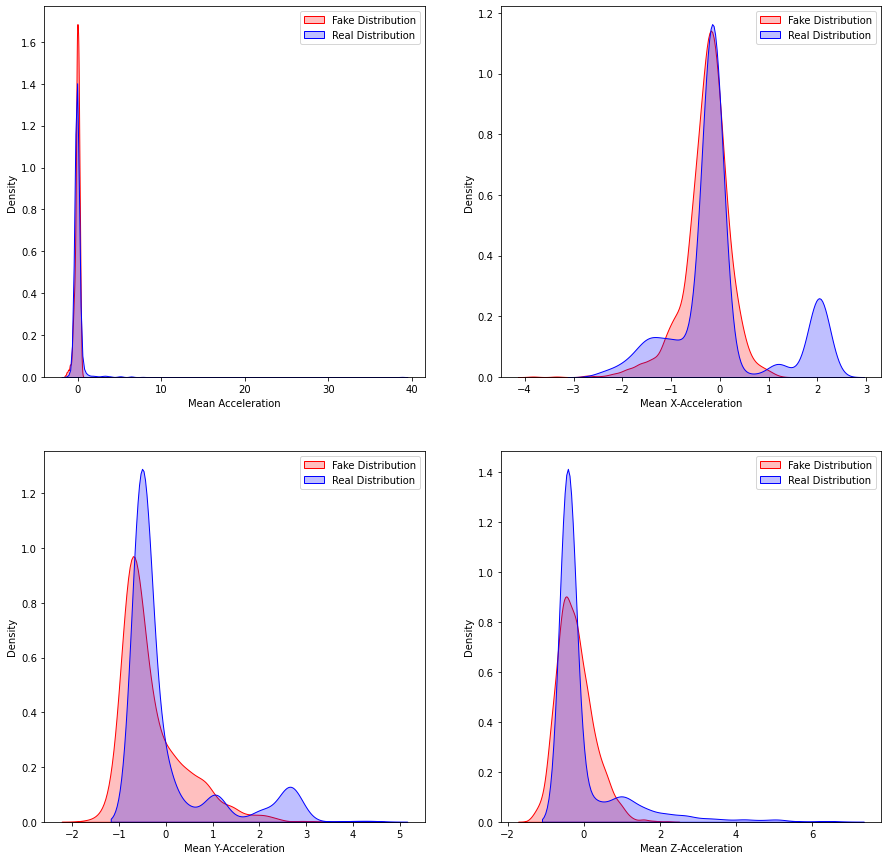

In [10]:
#Number of datum to visualize
sample_size = len(X)
reals = X[0:sample_size, :]
fakes = get_fake_samples(gen, sample_size, z_dim).detach()
density_curves(reals, fakes)

In [14]:
model_output = pd.read_csv('../model_outputs/1k_5_2_constant_GAN.csv')
model_output.head()

def plot_metrics(data, vanilla = True):
    if vanilla:
        sns.set(style = 'whitegrid', context = 'talk', palette = 'rainbow')
    
        plt.figure(figsize = (15, 15))
        subplot(2, 2, 1)
        sns.scatterplot(x = 'Epoch', y = 'FPR', data = data).set(xlim = (0, None))
        sns.despine()
        
        subplot(2, 2, 2)
        sns.scatterplot(x = 'Epoch', y = 'Recall', data = data).set(xlim = (0, None))
        sns.despine()
        
        subplot(2, 2, 3)
        sns.regplot(x = 'Epoch', y = 'Median Wasserstein', data = data, line_kws = {'color': 'orange'}).set(xlim = (0, None))
        sns.despine()
        
        subplot(2, 2, 4)
        sns.regplot(x = 'Epoch', y = 'Mean Wasserstein', data = data, line_kws = {'color': 'orange'}).set(xlim = (0, None))
        sns.despine()
        plt.show()
    else:
        sns.set(style = 'whitegrid', context = 'talk', palette = 'rainbow')
        plt.figure(figsize = (15, 8))
        
        subplot(1, 2, 1)
        sns.regplot(x = 'Epoch', y = 'Median Wasserstein', data = data, line_kws = {'color': 'orange'}).set(xlim = (0, None))
        sns.despine()
        
        subplot(1, 2, 2)
        sns.regplot(x = 'Epoch', y = 'Mean Wasserstein', data = data, line_kws = {'color': 'orange'}).set(xlim = (0, None))
        sns.despine()
        
        plt.show()

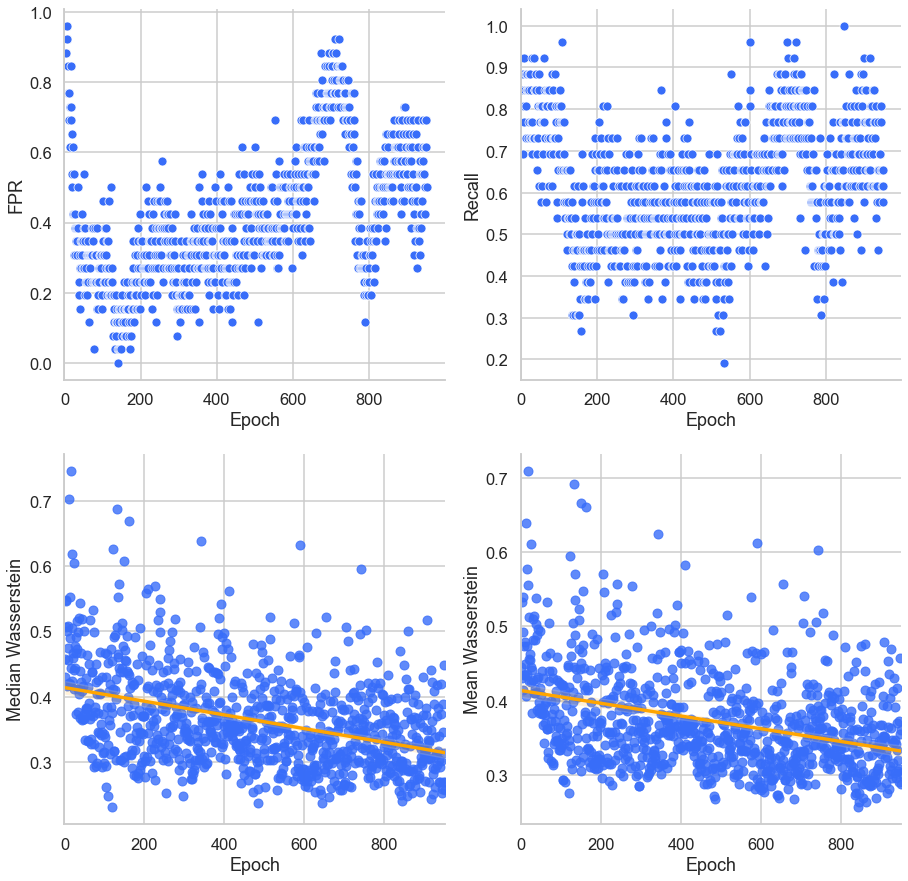

In [15]:
plot_metrics(model_output, True)

# Real/Fake Train Evaluation Metric

In [13]:
def generate_fake_real_dataset(gen, data, scaler):
    data = interpolation(data) #Interpolates entire dataframe
    not_sitting = data[data['label:SITTING'] == 0] #Only selects rows where sitting is 0
    real_features = not_sitting.iloc[:,1:27] #Selects only acceleration columns
    
    real_features = real_features.values #Converting to a numpy array
    real_features = scaler.transform(real_features) # These are all the scaled acceleration features for non-sitting real data
    real_features_size = real_features.shape[0] #Number of real samples
    y_label_notsitting = [0] * real_features_size #0 corresponds to the non-sitting class
    y_label_notsitting = np.asarray(y_label_notsitting).reshape(-1, 1) #Reshaping into a 2D column vector
    
    #Generating fake acceleration features for sitting data
    latent_vectors = get_noise(real_features_size, z_dim) #Generate the same number of fake sitting samples as real non-sitting samples
    fake_features = gen(latent_vectors).detach().numpy() #Generator already creates scaled features, so no scaling necessary
    y_label_sitting = [1] * real_features_size
    y_label_sitting = np.asarray(y_label_sitting).reshape(-1, 1)
    
    #Concatenating fake/real features and labels
    all_features = np.concatenate((real_features, fake_features), axis = 0) #Vertical concatenation
    all_labels = np.concatenate((y_label_notsitting, y_label_sitting), axis = 0).flatten() #Flatten 2D vector into 1D array for LogisticRegression
    
    #Splitting into train/test sets
    X_train, X_test, y_train, y_test = train_test_split(all_features, all_labels, test_size = 0.2, shuffle = True)
    return X_train, y_train, X_test, y_test

def generate_real_dataset(data, scaler):
    data = interpolation(data) #Interpolating the entire dataframe
    features = data.iloc[:,1:27] #Selecting only acceleration columns
    features = features.values #Converting to a numpy array
    features = scaler.transform(features) #Scaling all rows in the dataframe
    labels = data['label:SITTING'].values
    
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = 0.2, shuffle = True)
    return X_train, y_train, X_test, y_test

def train_test_real_fake(X_train, y_train, X_test, y_test):
    classifier = LogisticRegression(penalty = 'l2', C = 0.8)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    f1 = classifier_performance(y_pred, y_test)
    return f1

def train_test_real(X_train, y_train, X_test, y_test): 
    classifier = LogisticRegression(penalty = 'l2', C = 0.8)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    f1 = classifier_performance(y_pred, y_test)
    return f1

def classifier_performance(y_pred, y_test):
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    
    for k in range(len(y_pred)):
        #True positive
        if y_test[k] == 1 and y_pred[k] == 1:
            tp += 1
        #False Negative
        elif y_test[k] == 1 and y_pred[k] == 0:
            fn += 1
        #True Negative
        elif y_test[k] == 0 and y_pred[k] == 0:
            tn += 1
        elif y_test[k] == 0 and y_pred[k] == 1:
            fp += 1
        else:
            print("Error")
            exit()
            
    acc = (tp + tn)/(tp + tn + fp + fn)

    if tp + fp == 0:
        precision = 0
    else:
        precision = tp / (tp + fp)

    if tp + fn == 0:
        recall = 0
    else:
        recall = tp / (tp + fn)
    
    f1 = 2*(precision * recall / (precision + recall + 0.001))
    
    print(f'Precision: {precision:.3f} Recall: {recall:.3f} F-1 Score: {f1:.3f}')
    
    return acc, f1